# Estudo sobre transferencia de aprendizagem

## bibliotecas e base de dados

importação das bibliotecas

In [1]:
#biblioteca para manipulação de dados
import numpy as np
#bibliotecas para gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#biblioteca para manipulação de imagens
import cv2
from google.colab.patches import cv2_imshow
#biblioteca para manipulação de arquivo
import zipfile
#biblioteca para rede neural
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout

montagem do drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


pegando o dataset

In [3]:
caminho = '/content/drive/MyDrive/estudo de visao computacional/Datasets/homer_bart_2.zip'
zipado = zipfile.ZipFile(file = caminho, mode = 'r')
zipado.extractall('./')
zipado.close()

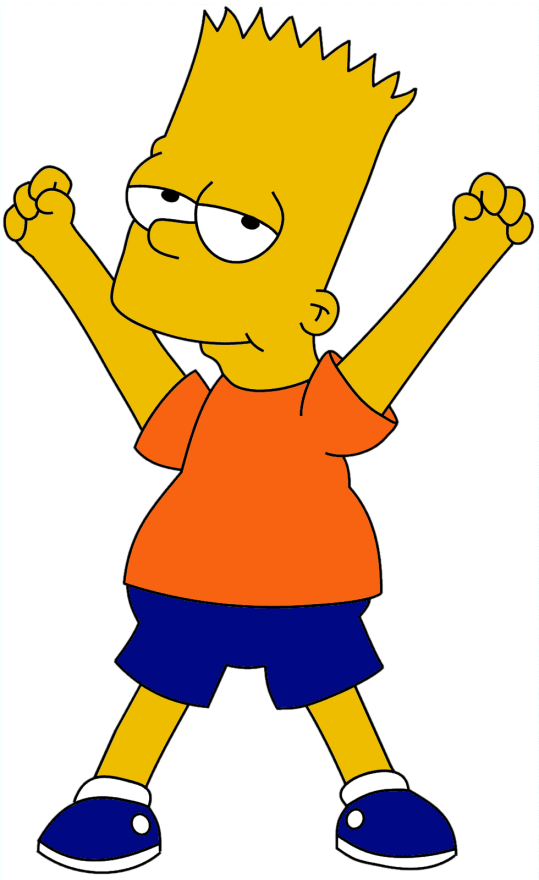

In [4]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart122.bmp')

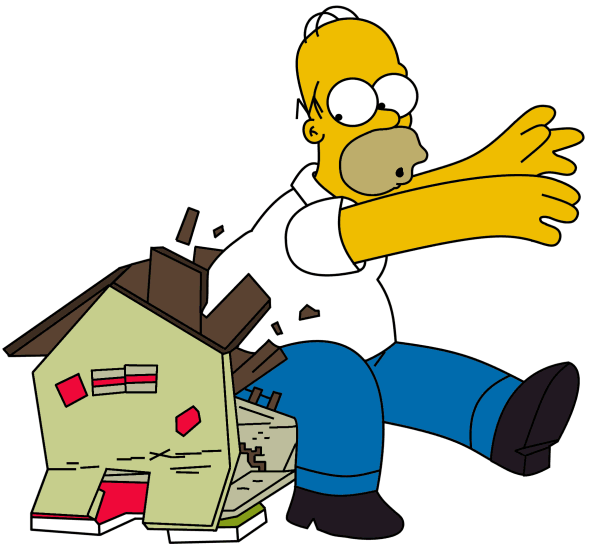

In [5]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/homer/homer123.bmp')

##Gerando as bases de treino e teste

In [6]:
gerador_treino = ImageDataGenerator(rescale=1./255, rotation_range=7, horizontal_flip= True, zoom_range=0.2)
base_treino = gerador_treino.flow_from_directory('/content/homer_bart_2/training_set',
                                                 target_size=(256,256),
                                                 batch_size = 8,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 215 images belonging to 2 classes.


In [7]:
gerador_teste = ImageDataGenerator(rescale=1./255)
base_teste = gerador_teste.flow_from_directory('/content/homer_bart_2/test_set',
                                               target_size = (256,256),
                                               batch_size=1,
                                               class_mode='categorical',
                                               shuffle=False)

Found 54 images belonging to 2 classes.


carregar rede neural pré treinada do proprio tensorflow

In [8]:
modelo_base = tf.keras.applications.ResNet50(weights = 'imagenet', include_top=False,
                                             input_tensor= Input(shape= (256,256,3))) #include top = colocar ou não a camada densa

94765736/94765736 [==============================] - 1s 0us/step


In [9]:
modelo_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
len(modelo_base.layers)

175

In [11]:
#congelando os pesos para o treinamento
for layer in modelo_base.layers:
  layer.trainable = False

construção da camada densa personalizada

In [12]:
modelo_base.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

quantidade de neuronios = (2048 + 2) / 2 = 1025

In [13]:
cabeca_modelo = modelo_base.output
cabeca_modelo = GlobalAveragePooling2D()(cabeca_modelo)
cabeca_modelo = Dense(units=1025, activation = 'relu')(cabeca_modelo)
cabeca_modelo = Dropout(rate=0.2)(cabeca_modelo)
cabeca_modelo = Dense(units=1025, activation = 'relu')(cabeca_modelo)
cabeca_modelo = Dropout(rate=0.2)(cabeca_modelo)
cabeca_modelo = Dense(units = 2, activation = 'softmax')(cabeca_modelo)

construção e treinamento

In [14]:
rede = Model(inputs = modelo_base.inputs, outputs = cabeca_modelo)

In [15]:
rede.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
rede.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historico = rede.fit(base_treino, epochs=50)

Epoch 1/50
27/27 [==============================] - 68s 2s/step - loss: 1.4880 - accuracy: 0.4977
Epoch 2/50
27/27 [==============================] - 58s 2s/step - loss: 0.6766 - accuracy: 0.6047
Epoch 3/50
27/27 [==============================] - 75s 3s/step - loss: 0.6783 - accuracy: 0.6233
Epoch 4/50
27/27 [==============================] - 74s 3s/step - loss: 0.6645 - accuracy: 0.6372
Epoch 5/50
27/27 [==============================] - 64s 2s/step - loss: 0.6472 - accuracy: 0.5907
Epoch 6/50
27/27 [==============================] - 64s 2s/step - loss: 0.5917 - accuracy: 0.6605
Epoch 7/50
27/27 [==============================] - 73s 3s/step - loss: 0.6303 - accuracy: 0.6419
Epoch 8/50
27/27 [==============================] - 65s 2s/step - loss: 0.5893 - accuracy: 0.6744
Epoch 9/50
27/27 [==============================] - 60s 2s/step - loss: 0.5560 - accuracy: 0.7256
Epoch 10/50
27/27 [==============================] - 71s 3s/step - loss: 0.6129 - accuracy: 0.6884
Epoch 11/50
27/27 [

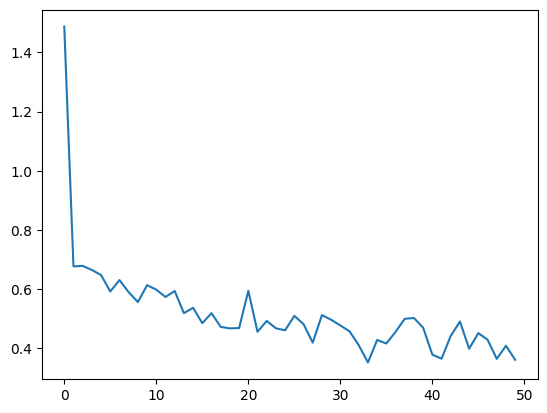

In [ ]:
plt.plot(historico.history['loss'])

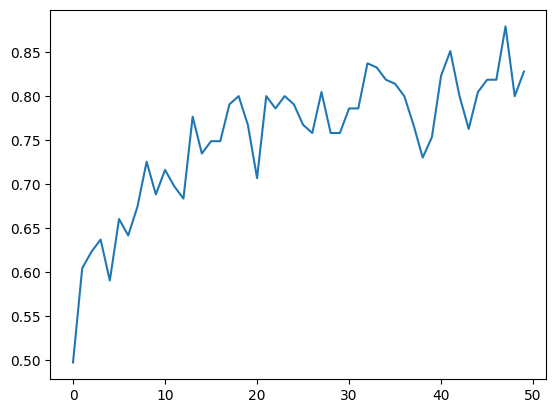

In [ ]:
plt.plot(historico.history['accuracy'])

In [ ]:
previsoes = rede.predict(base_teste)
previsoes

54/54 [==============================] - 15s 258ms/step


array([[9.40718114e-01, 5.92818744e-02],
       [8.69901061e-01, 1.30098939e-01],
       [8.80305469e-02, 9.11969483e-01],
       [9.76884425e-01, 2.31156312e-02],
       [9.63623106e-01, 3.63769010e-02],
       [9.68508422e-01, 3.14915851e-02],
       [7.92037870e-04, 9.99208033e-01],
       [7.12953448e-01, 2.87046582e-01],
       [5.06670356e-01, 4.93329614e-01],
       [5.63078642e-01, 4.36921328e-01],
       [9.18085352e-02, 9.08191502e-01],
       [9.47138309e-01, 5.28617017e-02],
       [9.52730238e-01, 4.72696982e-02],
       [3.07911754e-01, 6.92088246e-01],
       [8.06371629e-01, 1.93628430e-01],
       [9.87426162e-01, 1.25737898e-02],
       [1.05348542e-01, 8.94651473e-01],
       [5.21894336e-01, 4.78105634e-01],
       [9.40838039e-01, 5.91619499e-02],
       [9.67388213e-01, 3.26118693e-02],
       [1.06882356e-01, 8.93117726e-01],
       [9.50374186e-01, 4.96258363e-02],
       [9.99690652e-01, 3.09319701e-04],
       [7.98099637e-01, 2.01900408e-01],
       [9.747102

In [ ]:
previsoes= np.argmax(previsoes, axis = 1)

In [ ]:
previsoes

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(base_teste.classes, previsoes)

0.8703703703703703

<Axes: >

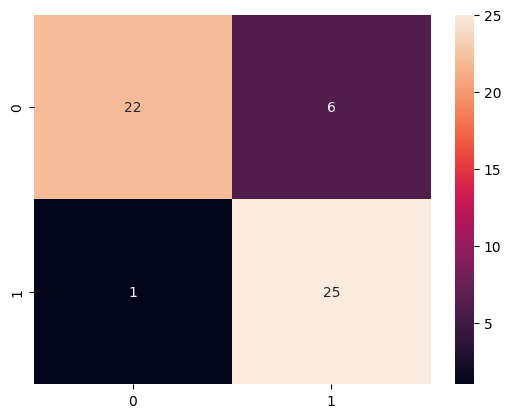

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(base_teste.classes, previsoes)
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report as cr
print(cr(base_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.96      0.79      0.86        28
           1       0.81      0.96      0.88        26

    accuracy                           0.87        54
   macro avg       0.88      0.87      0.87        54
weighted avg       0.88      0.87      0.87        54



## Fine tunning <br>
treinar algumas camadas de max pooling para melhor adaptação da rede

In [ ]:
modelo_base.trainable = True
fine_tunning_at = 140
#aplicamos o fine tunning a partir da camada 140, é importante que ele seja aplicado o mais próximo possivel das camadas densas

In [ ]:
for layer in modelo_base.layers[:fine_tunning_at]:
  layer.trainable=False

In [ ]:
#ja que alteramos as camadas, não será necessário criar outra rede, pois as alterações no modelo base se dão na rede tambem
rede.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
historico = rede.fit(base_treino, epochs = 50) #com o fine tunning é interessante rodar com mais épocas